In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [3]:
import numpy as np
from functools import partial
import tensorflow as tf
import scipy

from scipy.io import loadmat
from keras.layers import Input

from vdae.networks import VDAE, SpectralNet
from vdae.vdae_util import *

%matplotlib inline

/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/fl276/projects/Spe

# DATASET

In [4]:
dataset = 'loop'

if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255 
    latent_dim = 10
    bsize = 512
elif dataset == 'coil20hr':
    d_in = scipy.io.loadmat('data/COIL20_UNPROC_128.mat')
    X = d_in['X'] / np.max(d_in['X'])
    Y = d_in['Y']-1
    Y = Y.reshape(-1)
    x_train, x_test = X.reshape((len(X), -1)), X.reshape((len(X), -1))
    y_train, y_test = Y, Y
    latent_dim = 10
    bsize = 256
elif dataset == 'bulldog':
    (x_train, y_train), (x_test, y_test) = generate_bulldog()
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=5000, train_set_fraction=0.85)
    latent_dim = 3
    bsize = len(x_train)
elif dataset == 'faces':
    (x_train, y_train), (x_test, y_test) = generate_faces()
    latent_dim = 5
    bsize = len(x_train)

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if 'mnist' not in dataset and 'cifar' not in dataset and 'bulldog' not in dataset and 'gaussian_grid' not in dataset:
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b

arch = [
    {'type': 'relu', 'size': 500},
    {'type': 'linear', 'size': latent_dim},
    ]

# TRAIN SPECTRALNET

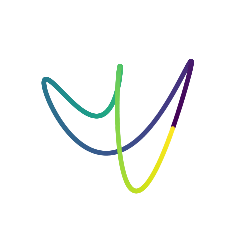

In [5]:
g = plot(x_train, y_train)

In [6]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }

In [7]:
spectral_net = SpectralNet(inputs=inputs, arch=arch,
                spec_reg=None, y_true=y_true, y_train_labeled_onehot=y_train_labeled_onehot,
                n_clusters=n_clusters, affinity='full', scale_nbr=3, n_nbrs=12, 
                batch_sizes=batch_sizes, siamese_net=None, 
                x_train=x_train, have_labeled=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
IMPORTANT: [<tf.Variable 'Unlabeled/spectral_0/kernel:0' shape=(3, 500) dtype=float32>, <tf.Variable 'Unlabeled/spectral_0/bias:0' shape=(500,) dtype=float32>, <tf.Variable 'Unlabeled_1/spectral_1/kernel:0' shape=(500, 3) dtype=float32>, <tf.Variable 'Unlabeled_1/spectral_1/bias:0' shape=(3,) dtype=float32>] <tf.Variable 'ortho_weights_store:0' shape=(3, 3) dtype=float32_ref>


In [8]:
spectral_net.net.trainable_weights

[<tf.Variable 'Unlabeled/spectral_0/kernel:0' shape=(3, 500) dtype=float32>,
 <tf.Variable 'Unlabeled/spectral_0/bias:0' shape=(500,) dtype=float32>,
 <tf.Variable 'Unlabeled_1/spectral_1/kernel:0' shape=(500, 3) dtype=float32>,
 <tf.Variable 'Unlabeled_1/spectral_1/bias:0' shape=(3,) dtype=float32>]

In [9]:
spectral_net.train(
            x_train, np.zeros_like(x_train[0:0]), x_test,
            lr=1e-5, drop=0.1, patience=20, num_epochs=200)

Epoch: 0, val_loss=0.000000


InternalError: Invalid variable reference.
	 [[node RMSProp/update_Unlabeled_1/spectral_1/bias/ResourceApplyRMSProp (defined at /Users/fl276/projects/SpectralVAEGAN/vdae/networks.py:157) ]]

Caused by op 'RMSProp/update_Unlabeled_1/spectral_1/bias/ResourceApplyRMSProp', defined at:
  File "/Users/fl276/.pyenv/versions/3.7.8/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/fl276/.pyenv/versions/3.7.8/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/Users/fl276/.pyenv/versions/3.7.8/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/Users/fl276/.pyenv/versions/3.7.8/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/Users/fl276/.pyenv/versions/3.7.8/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-baa22c7a6414>", line 5, in <module>
    x_train=x_train, have_labeled=False)
  File "/Users/fl276/projects/SpectralVAEGAN/vdae/networks.py", line 157, in __init__
    self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/training/optimizer.py", line 413, in minimize
    name=name)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/training/optimizer.py", line 612, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/training/optimizer.py", line 171, in update_op
    update_op = optimizer._resource_apply_dense(g, self._v)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/training/rmsprop.py", line 194, in _resource_apply_dense
    use_locking=self._use_locking)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/training/gen_training_ops.py", line 2357, in resource_apply_rms_prop
    use_locking=use_locking, name=name)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/fl276/projects/SpectralVAEGAN/venv/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InternalError (see above for traceback): Invalid variable reference.
	 [[node RMSProp/update_Unlabeled_1/spectral_1/bias/ResourceApplyRMSProp (defined at /Users/fl276/projects/SpectralVAEGAN/vdae/networks.py:157) ]]


In [ ]:
y_pred = spectral_net.predict(x_train)
g = plot(y_pred[:,:3], y_train.reshape(-1,))

In [ ]:
# plot images over embeddings
if 'mnist' in dataset or 'cifar' in dataset or 'coil' in dataset or 'faces' in dataset:
    zoom = 1
    if 'mnist' in dataset:
        img_shape = (28, 28)
    elif 'cifar' in dataset:
        img_shape = (32, 32, 3)
    elif 'coil' in dataset and 'hr' in dataset:
        img_shape = (128, 128)
        zoom = 0.2
    elif 'coil' in dataset:
        img_shape = (32, 32)
    elif 'faces' in dataset:
        img_shape = (28, 20)
        zoom = 2
    _ = imscatter(y_pred[p,0], y_pred[p,1], x_train[p], shape=img_shape, zoom=zoom)

# TRAIN VDAE

In [ ]:
arch

In [ ]:
svg_bsize = 288
svg_k = 2
svg_arch = [500]

svg = VDAE(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[1:], k=svg_k, alpha=1., arch=svg_arch)

In [ ]:
svg.train(x_train, epochs=5000, batch_size=svg_bsize, full_batch=True)

In [ ]:
# take a random walk step of a point. then plot its nearest neighbor
x_recon, z_mu, z_sigma_v, z_sigma_lam, _x_enc = svg.generate_from_samples(x_train, return_mu_sigma=True, normalize_cov=False)

In [ ]:
plot(x_recon[:1000], y_train[:1000])

# ANALYSIS

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)#, normalize_cov=0.)
def walk(f, x_arr, branch_factor=20, n_steps=10, max_size=5000):
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
    orig_shape = (-1,) + (x_arr.shape[1:])
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape(orig_shape)
        (x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:max_size]
        x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = x_arr[p], z_mu[p], z_sigma_v[p], z_sigma_lam[p], _x_enc[p]
        x_arr = x_arr.reshape(orig_shape)
    
    p = np.random.permutation(len(x_arr))[:max_size]
    x_arr = x_arr[p]
        
    return x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc

# NOW GENERATE all data points
max_size = min(1000, len(x_train))
x_arrs = []
test_size = len(x_train)
n_ = 0
while n_ < test_size:
    p = np.random.permutation(len(x_test))[:200]
    x_test_sample = x_test[p]
    x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=4, branch_factor=2, max_size=max_size)
    x_arrs.append(x_arr)
    n_ += len(x_arr)
    print("generated {}/{} points".format(n_, test_size), _x_enc.shape, x_arr.shape)

x_gens = np.concatenate(x_arrs, axis=0)[:len(x_train)]

# COMPUTE GROMOV-WASSERSTEIN
gw = gromorov_wasserstein_d(x_train, x_gens)

# COMPUTE BILIP CONSTANT
Ks = bilip(_x_enc, x_arr, 100)
print('Mean bi-Lipschitz constant: {:.4f} +- {:.4f}'.format(np.mean(Ks), np.std(Ks)))
print('Gromov-wasserstein distance: {:.4f}'.format(gw))

In [ ]:
# pick subset size
n_p = min(1000, len(x_train))
p = np.random.permutation(len(x_train))[:n_p]
x_train_p = x_train[p]
y_train_p = y_train[p]

# plot generated points
x_gen = svg.generate_from_samples(x_train_p, normalize_cov=False)
g = plot(x_gen, y_train_p, x2=x_train_p, s2=0)
p_train = np.random.permutation(len(x_train))[:n_p]

### RANDOM WALK TESTING

In [ ]:
p = np.random.permutation(len(x_test))[:1]
x_test_sample = x_test[p]
print('random walking on {}'.format(y_test[p]))
x_arr, z_mu, z_sigma_v, z_sigma_lam, _x_enc = walk(f, x_test_sample, n_steps=10)

In [ ]:
p = np.random.permutation(len(x_arr))
x_true_n_gen = np.concatenate([x_test_sample, x_arr[p]], axis=0)
g = plot(x_true_n_gen, shuffle=False)

In [ ]:
g, ax = plot(x_arr, x2=x_test, label1='predicted', label2='true', alpha2=0.2)
plt.title('predicted vs true points in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test)[1], label1='predicted', label2='true')
plt.title('predicted vs true points in latent space')

In [ ]:
g = plot(x_arr, x2=x_test_sample, label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in data space')

In [ ]:
g = plot(z_mu, x2=f(x_test_sample)[1], label1='predicted', label2='seed point', s2=1000)
plt.title('predicted vs initial seed point in latent space')